In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import datajoint as dj
from ibl_pipeline import subject
ephys = dj.create_virtual_module('ephys', 'ibl_ephys')


In [18]:
lab_name = "churchlandlab"
traj = ephys.ProbeInsertion * (ephys.ProbeTrajectory & 'insertion_data_source = "Micro-manipulator"') \
        * subject.Subject * (subject.SubjectLab & 'lab_name = "%s"'%lab_name)
traj = traj.proj('subject_nickname', 'x', 'y', 'theta', 'phi', 'theta', 'depth', 'probe_label', session_date='DATE(session_start_time)')
traj = traj.fetch(format='frame').reset_index()
traj['probe_phi'] = traj['phi'].map({180:'180deg', 0:'0deg'})
traj['angle'] = traj.theta

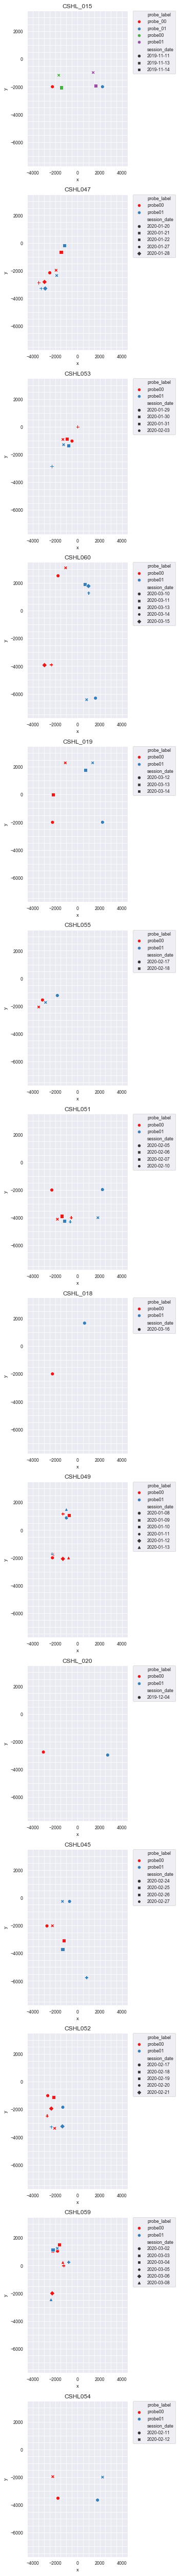

In [24]:
sns.set(style="darkgrid", context="paper")
g, axes = plt.subplots(traj.subject_nickname.nunique(), 1, figsize=(5,5*traj.subject_nickname.nunique()))

for probe, ax in zip(traj.subject_nickname.unique(), axes.flatten()):
    sns.scatterplot(data=traj[traj.subject_nickname==probe], 
                    x='x', y='y', hue="probe_label", style="session_date",
                    s=50, palette='Set1', legend='full', ax=ax)
    ax.set_title(probe, fontsize=12)
    ax.set(xlim=[-4500, 4500], ylim=[-7750, 3500])
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
#g.savefig(os.path.join(figpath, 'probe_trajectories_forhistology.pdf'))

In [23]:

# #### plot
# sns.set_style('darkgrid')
# plt.close('all')


# g = sns.FacetGrid(traj, col='subject_nickname', col_wrap=3,
#                   col_order=sorted(traj.subject_nickname.unique()),
#                   xlim=[-4500, 4500], ylim=[-7750, 3500])
# g.map(sns.scatterplot, 'x', 'y', hue=traj.probe_phi, style=traj.angle,
#       s=30, palette='Set1').add_legend(bbox_to_anchor=(1.10, 0.8))
# for ax in g.axes.flat:
#         ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#         ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#         ax.grid(b=True, which='minor')
